As Logistic Regression is mainly used for classification problems, it can't be used to predict exact stock prices.

We can instead try to reframe it into a classification problem. Where depending on different chosen attributes each day we classify the stock market price as going up or down (binary classification).

We will measure the 10-days moving average, correlation, RSI, and the open and close prices per day of a stock as the attributes to measure stock price fluctuations.

We can then take the predictions to try to calculate the returns for investments in buying and selling stocks when they go up or down.

Source Reference: https://blog.quantinsti.com/machine-learning-logistic-regression-python/

# Library Import


In [1]:
!pip install talib-binary

     |████████████████████████████████| 2.4 MB 5.6 MB/s 


In [2]:
#Necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #accessing directory structure
import talib as ta

#Logistic Regression
from sklearn.metrics import accuracy_score  
from sklearn.linear_model import LogisticRegression  
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [3]:
#Run this if your data is in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Cleaning and Setup


In [4]:
#Load Dataset
def loadData(fileLocation):
    df = pd.read_csv(fileLocation, delimiter = ',')
    df.columns=['Date','Open','High','Low','Close','Volume','OpenInt']
    df.drop('OpenInt', axis='columns', inplace=True)
    newdf=df[['Date','Open','High','Low','Volume','Close']]
    return df

In [6]:
#Open dataset
#df=loadData("/content/drive/MyDrive/Colab Notebooks/AI_Group/ArtificialIntelligence_UbiquantMarketPrediction/Data/ETFs/aadr.us.txt")
df=loadData("Data/ETFs/aadr.us.txt")
print(df.shape)
df['Date']=pd.to_datetime(df.Date,format="%Y-%m-%d")
df=df.set_index('Date')
df.head()

(1565, 6)


Open    High     Low   Close  Volume
Date                                              
2010-07-21  24.333  24.333  23.946  23.946   43321
2010-07-22  24.644  24.644  24.362  24.487   18031
2010-07-23  24.759  24.759  24.314  24.507    8897
2010-07-26  24.624  24.624  24.449  24.595   19443
2010-07-27  24.477  24.517  24.431  24.517    8456

In [7]:
#Calculating attributes, this is our x
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
x = df.iloc[:,:9]
x.head()

Open    High     Low   Close  Volume     S_10      Corr  \
Date                                                                    
2010-08-16  24.507  24.507  24.467  24.467    3094  24.8250 -0.513644   
2010-08-17  24.789  24.966  24.789  24.966    6704  24.8174 -0.517705   
2010-08-18  25.013  25.109  25.013  25.109     587  24.8214 -0.470713   
2010-08-19  24.966  24.966  24.966  24.966     513  24.8062 -0.426172   
2010-08-20  24.537  24.537  24.517  24.527    1238  24.7663 -0.321608   

                  RSI  Open-Close  
Date                               
2010-08-16  51.249287       0.106  
2010-08-17  61.674651       0.322  
2010-08-18  64.117971       0.047  
2010-08-19  59.876577      -0.143  
2010-08-20  48.853342      -0.429

In [8]:
#Calculating result value, this is our Y (Stock market going up or down)
# -1 = Stock Price going down
# 1 = Stock Price going up
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
y[:5]

array([ 1,  1, -1, -1,  1])

In [9]:
#Data Splitting 70-30 split
split = int(0.7*len(df))
x_train, x_test, y_train, y_test = x[:split], x[split:], y[:split], y[split:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1082, 9), (465, 9), (1082,), (465,))

# Model

In [10]:
#Model Creation
model = LogisticRegression()
model = model.fit(x_train,y_train)

[[0.44475786 0.55524214]
 [0.45150595 0.54849405]
 [0.52794    0.47206   ]
 [0.53216546 0.46783454]
 [0.42397115 0.57602885]]


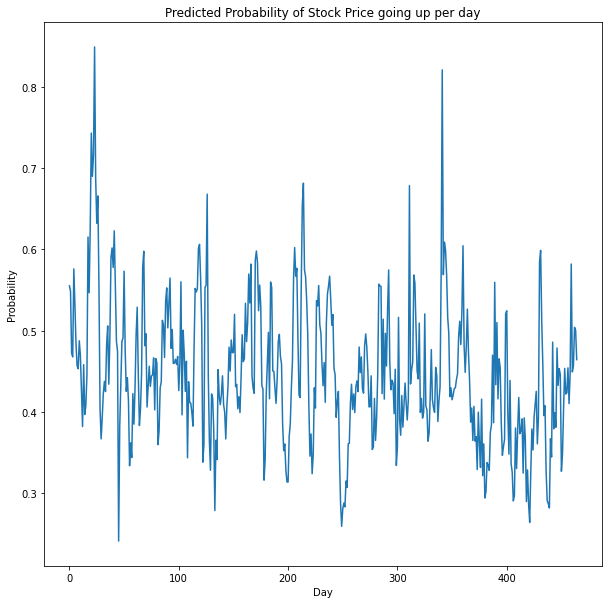

In [11]:
#Prints the calculated probability of stock price going up or down
probability = model.predict_proba(x_test)
print(probability[0:5]) #probability for first 5 days
plt.figure(figsize=(10,10))
plt.plot(probability[:,1])
plt.title('Predicted Probability of Stock Price going up per day')
plt.ylabel('Probability')
plt.xlabel('Day')
plt.show()

In [12]:
#Predict stock price trend
#-1 Down
# 1 Up
predicted = model.predict(x_test)
predicted[0:5]

array([ 1,  1, -1, -1,  1])

# Evaluation

In [13]:
#Accuracy report
accuracy = accuracy_score(y_test,predicted)*100  
print ("Model Prediction Accuracy")  
print(accuracy) 

Model Prediction Accuracy
52.04301075268817


In [14]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.49      0.80      0.61       214
           1       0.62      0.28      0.39       251

    accuracy                           0.52       465
   macro avg       0.55      0.54      0.50       465
weighted avg       0.56      0.52      0.49       465



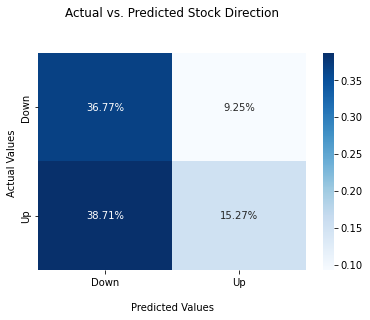

In [31]:
#Heatmap of predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted)
ax = sns.heatmap(cm/np.sum(cm), annot=True, cmap = 'Blues', fmt='.2%')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Down','Up'])
ax.yaxis.set_ticklabels(['Down','Up'])

ax.set_title('Actual vs. Predicted Stock Direction\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

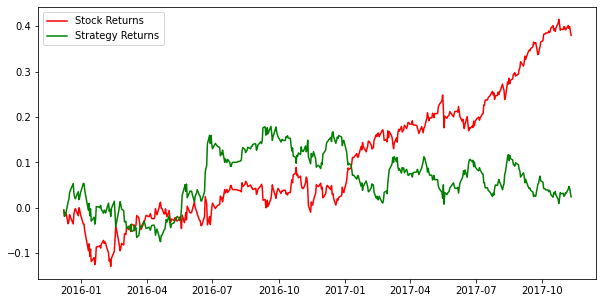

In [15]:
#Using predictions to predict returns
df['Predicted_Signal'] = model.predict(x)
df['stock_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_stock_returns = np.cumsum(df[split:]['stock_returns'])

df['Strategy_returns'] = df['stock_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Strategy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_stock_returns, color='r',label = 'Stock Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [16]:
#model evaluation
from sklearn.metrics import r2_score, mean_squared_error
print("R Squared Score: %.3f"%(r2_score(y_test, predicted)))
print("Mean Square Error %.3f"%(mean_squared_error(y_test, predicted)))

R Squared Score: -0.931
Mean Square Error 1.918
